# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [4]:
!pip install numpy

In [5]:
!pip install matplotlib

In [12]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 0, 'X3')

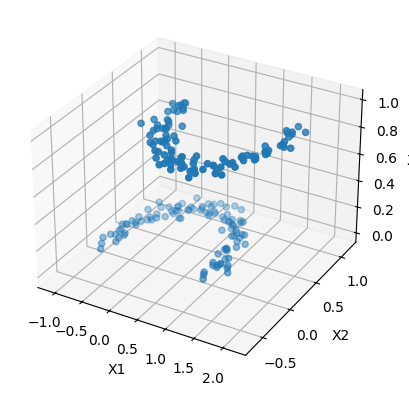

In [9]:
data = np.loadtxt('data/moonDataset.csv', delimiter=',', skiprows=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,3])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

In [10]:
X = data[:, :-1]
y = data[:, :-1]

In [11]:
def loss_accuracy_graph(train_hist):
    plt.figure(figsize=(12,7))
    plt.subplot(2,1,1)
    plt.plot(train_hist['train loss'], label='Training')
    if len(train_hist) == 4:
        plt.plot(train_hist['validation loss'], 'o', label='Validation')
    plt.title('MSE Loss')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(train_hist['train accuracy'])
    if len(train_hist) == 4:
        plt.plot(train_hist['validation accuracy'], 'o')
    plt.title('Accuracy')
    plt.grid(True)
    plt.show()

In [13]:
def predict_2D(neural_net, X):
    X_3D_temp = np.c_(X, np.zeros(X.shape[0]))
    return np.round(neural_net.predict(X_3D_temp))
    X_3D_temp = np.c_[X, np.zeros(X.shape[0])] 
    return np.round(neural_net.predict(X_3D_temp))

x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                       np.linspace(x2_min, x2_max, 100))

def plot_decision_boundary(model):
    Z = predict_2D(model, np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Decision Boundary for 2D Projection of Moons Dataset')

    plt.show()

Baseline Neural Network Construction and Evaluation

In [14]:
class NeuralNetwork():
    def __init__(self, hidden_size=16, initialization_method='he', textbook = False):
        self.textbook = textbook
        if self.textbook:
            self.hidden_layer_weights = np.array([[0.2, 0.4, -0.5],
                                                    [-0.3, 0.1, 0.2]])
            self.hidden_layer_biases = np.array([-0.4, 0.2])

            self.output_weights = np.array([-0.3, -0.2])
            self.output_bias = 0.1
        else:
            if initialization_method == 'he':
                self.hidden_layer_weights = np.random.normal(0, np.sqrt(2/3), (hidden_size, 3))
                self.hidden_layer_biases = np.zeros(hidden_size)

                self.output_weights = np.random.normal(0, np.sqrt(2/hidden_size), hidden_size)
                self.output_bias = 0

            elif initialization_method == 'xavier':
                self.hidden_layer_weights = np.random.normal(0, np.sqrt(2/(3+1)), (hidden_size, 3))
                self.hidden_layer_biases = np.zeros(hidden_size)

                self.output_weights = np.random.normal(0,np.sqrt(2/(hidden_size+1)), hidden_size)
                self.output_bias = 0
            else:
                raise ValueError

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _sigmoid_derivative(self, x):
        return self._sigmoid(x) * (1 - self._sigmoid(x))

    def _activation(self, x):
        if self.textbook:
            return self._sigmoid(x)
        else:
            pass
    
    def _activation_derivative(self, x):
        if self.textbook:
            return self._sigmoid_derivative(x)
        else:
            pass
    
    def MSE(self, y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    
    def accuracy(self, y_true, y_pred):
        return sum(y_true == y_pred) / len(y_true)
    
    def __squared_error_derivative(self, y_true, y_pred):
        return -2 * (y_true - y_pred)
    
    def __forward_pass(self, row):
        self.hidden_layer_net = self.hidden_layer_weights @ row + self.hidden_layer_biases
        self.hidden_layer_activations = self._activation(self.hidden_layer_net)
        self.output_net = self.output_weights @ self.hidden_layer_activations + self.output_bias
        self.output = self._sigmoid(self.output_net)

    def __SGD(self, y_true, y_pred, row):
        self.output_delta = self.__squared_error_derivative(y_true, y_pred) * self._sigmoid_derivative(self.output_net)
        self.output_bias_loss = self.output_delta
        self.output_weights_loss = self.output_delta * self.hidden_layer_activations

        self.hidden_layer_deltas = self.output_delta * self.output_weights * self._activation_derivative(self.hidden_layer_net)
        self.hidden_layer_biases_loss = self.hidden_layer_deltas
        self.hidden_layer_weights_loss = np.outer(self.hidden_layer_deltas, row)

    def __backward_pass(self, learning_rate):
        self.output_bias = self.output_bias - learning_rate * self.output_bias_loss
        self.output_weights = self.output_weights - learning_rate * self.output_weights_loss

        self.hidden_layer_biases = self.hidden_layer_biases - learning_rate * self.hidden_layer_biases_loss
        self.hidden_layer_weights = self.hidden_layer_weights - learning_rate * self.hidden_layer_weights_loss

    def predict(self, data):
        predictions = []
        for row in data:
            self.__forward_pass(row)
            predictions.append(self.output)
        return np.array(predictions)

    def fit(self, x, y, learning_rate=0.01, epochs=20, validation_split=0, verbose=False):
        train_history = {'train loss': [], 'train accuracy': []}
        if validation_split:
            train_history['validation loss'] = []
            train_history['validation accuracy'] = []

            vals = int(len(x) * validation_split)

            x_validate = x[:vals]
            y_validate = y[:vals]
            
            x = x[vals:]
            y = y[vals:]

        for epoch in range(epochs):
            for row in range(len(x)):
                self.__forward_pass(x[row])
                self.__SGD(y[row], self.output, x[row])
                self.__backward_pass(learning_rate)

            preds = self.predict(x)

            train_loss = self.MSE(y, preds)
            train_acc = self.accuracy(y, np.round(preds))

            if verbose:
                print(f'Epoch {epoch+1}: train loss: {train_loss:.2f} - train accuracy: {train_acc:.2f}', end=' ')

            train_history['train loss'].append(train_loss)
            train_history['train accuracy'].append(train_acc)

            if validation_split:
                val_preds = self.predict(x_validate)

                val_loss = self.MSE(y_validate, val_preds)
                val_acc = self.accuracy(y_validate, np.round(val_preds))

                if verbose:
                    print(f'| val loss: {val_loss:.2f} - val accuracy: {val_acc:.2f}', end='')

                train_history['validation loss'].append(val_loss)
                train_history['validation accuracy'].append(val_acc)
                
            if verbose:
                print('\n')
        
        return train_history

Model training and evaluation

In [16]:
mynn = NeuralNetwork(textbook=True)

train_hist = mynn.fit(X, y, learning_rate=0.1, epochs=20, validation_split=0.1, verbose=True)
loss_accuracy_graph(train_hist)
plot_decision_boundary(mynn)

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [ ]:
class SigmoidNN(NeuralNetwork):
    def _activation(self, x):
        return 1/(1 + np.exp(-x))
    
    def _activation_derivative(self, x):
        return self._activation(x)  * (1 - self._activation(x))

In [ ]:
sigmoid_model = SigmoidNN(16, 'xavier')

sigmoid_train_hist = sigmoid_model.fit(X, y, learning_rate=0.5, epochs=20, validation_split=0.1)
loss_acc_graph(sigmoid_train_hist)
plot_decision_boundary(sigmoid_model)

In [ ]:
class ReluNN(NeuralNetwork):
    def _activation(self, x):
        return np.maximum(0, x)
    
    def _activation_derivative(self, x):
        return np.where(x>0, 1, 0)

In [ ]:
relu_model = ReluNN(16, 'he')

relu_train_hist = relu_model.fit(X, y, learning_rate=0.5, epochs=20, validation_split=0.1)
loss_acc_graph(relu_train_hist)
plot_decision_boundary(relu_model)

In [ ]:
class TanhNN(NeuralNetwork):
    def _activation(self, x):
        return np.tanh(x)
    
    def _activation_derivative(self, x):
        return 1 - np.tanh(x)**2

In [ ]:
tanh_model = TanhNN(16, 'xavier')

tanh_train_hist = tanh_model.fit(X, y, learning_rate=0.5, epochs=20, validation_split=0.1)
loss_acc_graph(tanh_train_hist)
plot_decision_boundary(tanh_model)

In [ ]:
class LeakyReluNN(NeuralNetwork):
    def _activation(self, x):
        return np.maximum(0.01*x, x)
    
    def _activation_derivative(self, x):
        return np.where(x>0, 1, 0.01)

In [ ]:
lr_model = LeakyReluNN(16, 'he')

lr_train_hist = lr_model.fit(X, y, learning_rate=0.5, epochs=20, validation_split=0.1)
loss_acc_graph(lr_train_hist)
plot_decision_boundary(lr_model)

In [ ]:
class SwishNN(NeuralNetwork):
    def _activation(self, x):
        return x/(1 + np.exp(-x))
    
    def _activation_derivative(self, x):
        return 1/(1 + np.exp(-x)) + x * ((1/(1 + np.exp(-x)))  * (1 - (1/(1 + np.exp(-x)))))

In [ ]:
swish_model = SwishNN(16, 'he')

swish_train_hist = swish_model.fit(X, y, learning_rate=0.5, epochs=20, validation_split=0.1)
loss_acc_graph(swish_train_hist)
plot_decision_boundary(swish_model)

In [ ]:
class EluNN(NeuralNetwork):
    def _activation(self, x):
        return np.where(x>=0, x, (np.exp(x) - 1))
    
    def _activation_derivative(self, x):
        return np.where(x>=0, 1, np.exp(x))

In [ ]:
elu_model = EluNN(16)

elu_train_hist = elu_model.fit(X, y, learning_rate=0.5, epochs=20, validation_split=0.1)
loss_acc_graph(elu_train_hist)
plot_decision_boundary(elu_model)

Conclusion 
The exploration into varying neural network architectures, coupled with the evaluation of different activation functions, has yielded insightful information regarding the performance of artificial neural networks. A critical takeaway from this investigation is the superior efficiency of the ReLU activation function in terms of convergence speed.

Conversely, the ELU and Sigmoid activation functions demonstrated a requirement for a greater number of epochs to reach convergence. This observation highlights the inherent trade-offs between activation function choice and training efficiency. While ELU and Sigmoid might offer advantages in specific scenarios, such as smoother gradients or output range constraints, their slower convergence rates suggest a potential for increased computational cost and training time in certain contexts.